## Consensus modelling for prediction of Blood-brain barrier penetration

This notebook takes as input the predictions of two predictive models (Jaqpot and Lazar; files: `predictions_jaqpot.csv` and `predictions_lazar.csv`), which classify compounds as BBB penetrating and non-penetrating, and makes a consensus prediction based on the Dempster-Shafer theory. Results are stored in `consensus_predictions.csv` and plotted in `predictions_vs_evidence.png` and `predictions_vs_true.png`. Intermediate results (combined evidence that is directly used for consensus predictions) are outputted into `evidences.csv`.

**NOTE:** in the input files the compounds are identified only through their SMILES. This script accesses the Pubchem and obtains the IUPAC names and synonyms for these compounds based on their SMILES strings. This is a time consuming step and therefore should be executed only once. It is recommended to build the dictionaries `smilesToName` and `smilesToSyn`, which map from the SMILES to the compound's IUPAC name or synonym, only once and then comment that part of the code.

#### Dempster-Shafer theory

Taking into account PPV and NPV of individual sources of evidence, there are two different rules how to combine these evidences to arrive at the final prediction: **Dempster** and **Yager rule**.

**1) Dempster rule (D):** puts more weight onto agreement between the various sources of evidence and tends to neglect disagreements.

**2) Yager rule (Y):** tends to put more weight on conflicting evidences, resulting in less certain predictions in such cases.

We have two sources of evidence, Lazar (L) and Jaqpot (J) model predictions. Each of these models predicts whether compound is BBB penetrating or non-penetrating and each of these predictions is described by its predictive value (PPV or NPV):

**Jaqpot = Source 1:**
- PPV = 0.738
- NPV = 0.687

**Lazar = Source 2:**
- PPV = average(0.8828, 0.8875, 0.8875)
- NPV = average(0.4683, 0.5159, 0.4841)

All this information is used to calculate **belief** that a compound is penetrating and **uncertainty**. The greater the **belief** for a prediction, the greater is the direct support from evidences for this prediction. **Uncertainty** represents lack of support of either prediction and **plausability** is composed of belief and uncertainty (i.e. covers all evidences, which don't contradict the hypothesis). The following statements are always true:

`Belief(Penetrating) + Uncertainty + Belief(Non-penetrating) = 1`

`Plausability(Penetrating) = Belief(Penetrating) + Uncertainty`

`Plausability(Non-penetrating) = Belief(Non-penetrating) + Uncertainty`

Consensus prediction is the one, which corresponds to the largest of the beliefs and uncertainty, hence:

- if `Belief(Penetrating)` is the largest factor in the first equation, compound is considered **penetrating**
- if `Belief(Non-penetrating)` is the largest factor in the first equation, compound is considered **non-penetrating**
- if `Uncertainty` is the largest factor in the first equation, consensus prediction is **equivocal** (not enough evidence to support either hypothesis).

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import dst  # custom module for Dempster-Shafer theory

**Import prediction of Jaqpot and Lazar models and drop the first column, which is just index**

In [208]:
df1 = pd.read_csv('predictions_jaqpot.csv')
df1 = df1.drop(columns=df1.columns[0])

df2 = pd.read_csv('predictions_lazar.csv')
df2 = df2.drop(columns=df2.columns[0])

**Drop duplicates in SMILES**

In [209]:
df1 = df1.drop_duplicates(subset="SMILES")
df2 = df2.drop_duplicates(subset="SMILES")

**Set SMILES as index for merging the datasets**

In [210]:
df1 = df1.set_index('SMILES')
df2 = df2.set_index('SMILES')

**Convert predictions of Lazar model to numerics**

In [211]:
df1 = df1.rename(columns={'Predicted': 'Predicted_J'})
df2['Predicted_L'] = df2['Prediction'].map({'penetrating': 1, 'non-penetrating': 0})

**Merge the two datasets**

In [212]:
pred = pd.merge(df1, df2[['Predicted_L']], on='SMILES')

**Drop NA (Lazar model has certain NA predictions)**

In [213]:
pred = pred.dropna()

**Print the filtered predictions of both models in the csv file**

In [214]:
pred.to_csv('evidences.csv')

pred.head()

,Blood-Brain-Barrier Penetration,Predicted_J,Predicted_L
SMILES,,,
OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)Cl)(O)C,0,1,1.0
NCCc1nc2n(c1)cccc2,0,1,1.0
CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,1,1,1.0
Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CCC[C@H]2O,1,1,1.0
Clc1ccc2-n3c(CN=C(c2c1)c1ccccc1)nnc3C,1,1,1.0


**Loop over chemicals in the "pred" dataframe. For each chemical compute belief and uncertainty and make a consensus prediction.**

Note that `dst` module uses symbols S and N to designate positive and negative predictions, which are in our case penetrating and non-penetrating compunds. In the next step, these symbols are renamed to the specific case of this notebook.

In [215]:
# initiate a list of dictionaries, which will be converted to dataframe of results then
results = []

for index, row in pred.iterrows():
    
    # initiate a list of basic mass probabilities for all sources of evidence
    m = []
    
    # source 0 - compute basic mass probabilities
    state = row['Predicted_J']
    ppv, npv = 0.738, 0.687
    m0 = dst.assignBasicMassProb(state, ppv, npv)
    m.append(m0)  # add to list

    # source 1 - compute basic mass probabilities
    state = row['Predicted_L']
    ppv, npv = np.average([0.8828, 0.8875, 0.8875]), np.average([0.4683, 0.5159, 0.4841])
    m1 = dst.assignBasicMassProb(state, ppv, npv)
    m.append(m1)  # add to list
    
    # assign ground mass probabilities
    qs = dst.assignGroundMassProb_N(m)
    
    # make consensus predictions based on the Yager or Dempster combination rule
    bel_Y, pls_Y, pred_Y = dst.predict(dst.YagerCombinationRule(qs))
    bel_D, pls_D, pred_D = dst.predict(dst.DempsterCombinationRule(qs))
    
    # collect results
    results.append({
        'SMILES': index,
        'Pred_Y': pred_Y,
        'Bel_Y': bel_Y['S'],
        'Pls_Y': pls_Y['S'],
        'Uncertainty_Y': pls_Y['S'] - bel_Y['S'],
        'Pred_D': pred_D,
        'Bel_D': bel_D['S'],
        'Pls_D': pls_D['S'],
        'Uncertainty_D': pls_D['S'] - bel_D['S']
    })

# convert results to a dataframe
consensus_pred = pd.DataFrame(results).replace({'S': 'penetrating', 'N': 'non-penetrating'})

**Set SMILES as index and convert numerical results to descriptive terms**

In [216]:
consensus_pred = consensus_pred.set_index('SMILES')

consensus_pred['True'] = pred['Blood-Brain-Barrier Penetration'].map({1: 'penetrating', 0: 'non-penetrating'})

consensus_pred['Lazar'] = pred['Predicted_L'].map({1: 'penetrating', 0: 'non-penetrating'})
consensus_pred['Jaqpot'] = pred['Predicted_J'].map({1: 'penetrating', 0: 'non-penetrating'})

**Store consensus predictions into csv file**

In [217]:
consensus_pred.to_csv('consensus_predictions.csv')

consensus_pred.head()

,Bel_D,Bel_Y,Pls_D,Pls_Y,Pred_D,Pred_Y,Uncertainty_D,Uncertainty_Y,True,Lazar,Jaqpot
SMILES,,,,,,,,,,,
OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)Cl)(O)C,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,non-penetrating,penetrating,penetrating
NCCc1nc2n(c1)cccc2,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,non-penetrating,penetrating,penetrating
CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,penetrating,penetrating,penetrating
Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CCC[C@H]2O,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,penetrating,penetrating,penetrating
Clc1ccc2-n3c(CN=C(c2c1)c1ccccc1)nnc3C,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,penetrating,penetrating,penetrating


**Confusion matrix for Lazar predictive model**

In [218]:
pd.crosstab(consensus_pred['True'], consensus_pred['Lazar'])

Lazar,non-penetrating,penetrating
True,,
non-penetrating,57,61
penetrating,23,202


**Confusion matrix for Jaqpot predictive model**

In [219]:
pd.crosstab(consensus_pred['True'], consensus_pred['Jaqpot'])

Jaqpot,non-penetrating,penetrating
True,,
non-penetrating,64,54
penetrating,33,192


**Confusion matrix for consensus prediction with Yager combination rule**

In [220]:
pd.crosstab(consensus_pred['True'], consensus_pred['Pred_Y'])

Pred_Y,equivocal,non-penetrating,penetrating
True,,,
non-penetrating,59,31,28
penetrating,48,4,173


**Confusion matrix for consensus prediction with Dempster combination rule**

In [221]:
pd.crosstab(consensus_pred['True'], consensus_pred['Pred_D'])

Pred_D,non-penetrating,penetrating
True,,
non-penetrating,31,87
penetrating,4,221


**Confusion matrix for a combination of evidences**

In [222]:
pd.crosstab(consensus_pred['True'], [consensus_pred['Lazar'], consensus_pred['Jaqpot']])

Lazar           non-penetrating                 penetrating            
Jaqpot          non-penetrating penetrating non-penetrating penetrating
True                                                                   
non-penetrating              31          26              33          28
penetrating                   4          19              29         173

**Observations:**

- With the consensus predictions, the number of fales-negatives decreases a lot. Only the 4 compounds that are mistakenly predicted as non-penetrating by both predictive models, Jaqpot and Lazar, are false negatives by consensus approach.

- When evidence is conflicting, the Dempster rule, which neglects disagreements, predicts penetrating compounds, which results in a larger number of false positives. 

- On the other hand, Yager rule increases the uncertainty in these cases, resulting in larger number of equivocal predictions and lower numbers of false positives and false negatives.

**Visualization of consensus prediction (Yager rule) for different combinations of evidences**

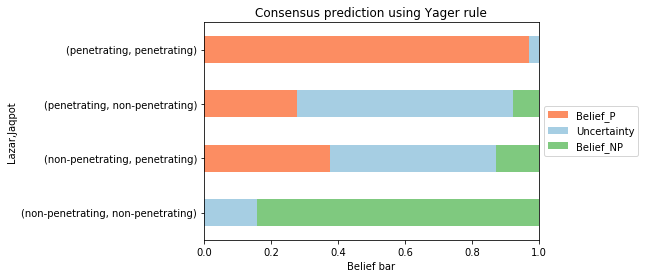

In [223]:
source = consensus_pred.groupby(['Lazar', 'Jaqpot']).mean()[['Bel_Y', 'Uncertainty_Y']]
source['Belief_NP'] = 1. - source['Bel_Y'] - source['Uncertainty_Y']
source = source.rename(columns={'Bel_Y': 'Belief_P', 'Uncertainty_Y': 'Uncertainty'})
source

my_palette = ['#fc8d62', '#a6cee3', '#7fc97f']
ax = source.plot.barh(stacked=True, color=my_palette, xlim=(0., 1.), title="Consensus prediction using Yager rule").set_xlabel("Belief bar");

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig = ax.get_figure()
fig.savefig('a.png', bbox_inches='tight')

**Visualization of consensus prediction (Dempster rule) for different combinations of evidences**

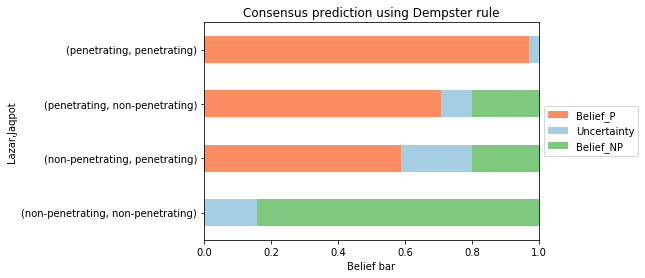

In [224]:
source = consensus_pred.groupby(['Lazar', 'Jaqpot']).mean()[['Bel_D', 'Uncertainty_D']]
source['Belief_NP'] = 1. - source['Bel_D'] - source['Uncertainty_D']
source = source.rename(columns={'Bel_D': 'Belief_P', 'Uncertainty_D': 'Uncertainty'})
source

my_palette = ['#fc8d62', '#a6cee3', '#7fc97f']
ax = source.plot.barh(stacked=True, color=my_palette, xlim=(0., 1.), title="Consensus prediction using Dempster rule").set_xlabel("Belief bar");

plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()
fig = ax.get_figure()
fig.savefig('a.png', bbox_inches='tight')

**Collect compound names (mapping from SMILES to IUPAC name)**

In [225]:
consensus_pred = consensus_pred.reset_index()
consensus_pred.head()

,SMILES,Bel_D,Bel_Y,Pls_D,Pls_Y,Pred_D,Pred_Y,Uncertainty_D,Uncertainty_Y,True,Lazar,Jaqpot
0,OC[C@](c1onc(n1)c1ncn2-c3cccc(c3C(=O)N(Cc12)C)...,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,non-penetrating,penetrating,penetrating
1,NCCc1nc2n(c1)cccc2,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,non-penetrating,penetrating,penetrating
2,CCCN(CCC)CCc1ccc(c2c1CC(=C)N2)O,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,penetrating,penetrating,penetrating
3,Fc1ccc2c(c1)onc2C1CCN(CC1)CCc1c(C)nc2n(c1=O)CC...,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,penetrating,penetrating,penetrating
4,Clc1ccc2-n3c(CN=C(c2c1)c1ccccc1)nnc3C,0.970115,0.970115,1.0,1.0,penetrating,penetrating,0.029885,0.029885,penetrating,penetrating,penetrating


**Collect compound info from Pubchem (NOTE: needed only once)**

In [226]:
smilesToName = {}

for smiles in consensus_pred['SMILES'].tolist():
    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/" + smiles + "/property/IUPACName/TXT"
    
    r = requests.get(url)
    
    if r.status_code == 200:
        name = r.text.strip('\n')
    else:
        name = smiles
        
    smilesToName[smiles] = name

**Collect compound info from Pubchem (NOTE: needed only once)**

In [227]:
smilesToSyn = {}

for smiles in consensus_pred['SMILES'].tolist():
    url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/smiles/" + smiles + "/synonyms/TXT"

    r = requests.get(url)
    
    if r.status_code == 200:
        name = r.text.split('\n')[0].upper()
    else:
        name = smiles
    
    smilesToSyn[smiles] = name

In [228]:
consensus_pred['Name'] = consensus_pred['SMILES'].map(smilesToName)
consensus_pred['Synonym'] = consensus_pred['SMILES'].map(smilesToSyn)

**Sort the compounds according to the experimental (`True` column) and input values (`Lazar` and `Jaqpot` columns). In this way, the true/false positives/negatives are grouped together and easier to distinguish.**

In [229]:
consensus_pred = consensus_pred.sort_values(by=['True', 'Lazar', 'Jaqpot'])

**Create column with names to be used in the plots**

In [230]:
consensus_pred['Name_True'] = consensus_pred['Synonym'].str[0:15] + '_' + consensus_pred['True']
consensus_pred['Name_Jaqpot_Lazar'] = consensus_pred['Synonym'].str[0:15] + '_' + consensus_pred['Jaqpot'] + '_' + consensus_pred['Lazar']

**Consensus prediction (Dempster rule) per compound's combination of evidences**

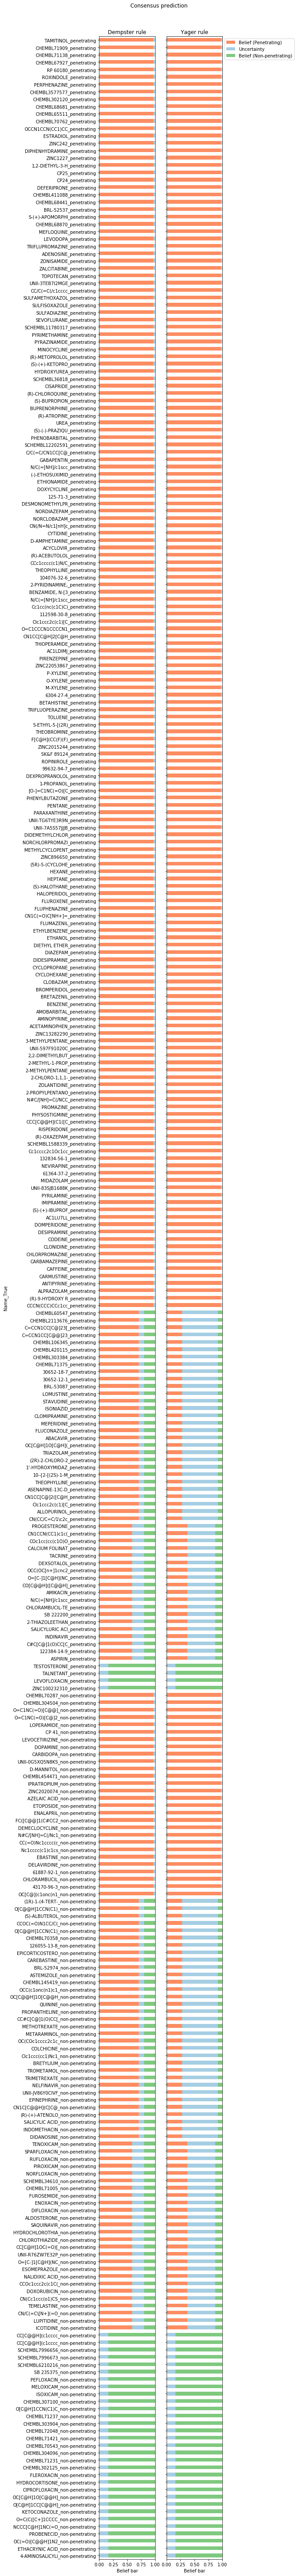

In [259]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(30, 110))


# PLOT 1
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_D'] - consensus_pred['Uncertainty_D']

df_plot = consensus_pred[['Bel_D', 'Uncertainty_D', 'Belief (Non-penetrating)', 'Jaqpot', 'Lazar', 'Name_True']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_D': 'Belief (Penetrating)', 'Uncertainty_D': 'Uncertainty'}).set_index(['Name_True'])
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Dempster rule", ax=ax1, legend=False).set_xlabel("Belief bar");


# PLOT 2
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_Y'] - consensus_pred['Uncertainty_Y']

df_plot = consensus_pred[['Bel_Y', 'Uncertainty_Y', 'Belief (Non-penetrating)', 'Jaqpot', 'Lazar', 'Name_True']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_Y': 'Belief (Penetrating)', 'Uncertainty_Y': 'Uncertainty'}).set_index(['Name_True'])
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Yager rule", ax=ax2).set_xlabel("Belief bar");

fig.suptitle("Consensus prediction", y=0.89)

plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

fig.savefig('prediction_vs_evidence.png', bbox_inches='tight')

**Consensus prediction (Dempster rule) per compound's true value**

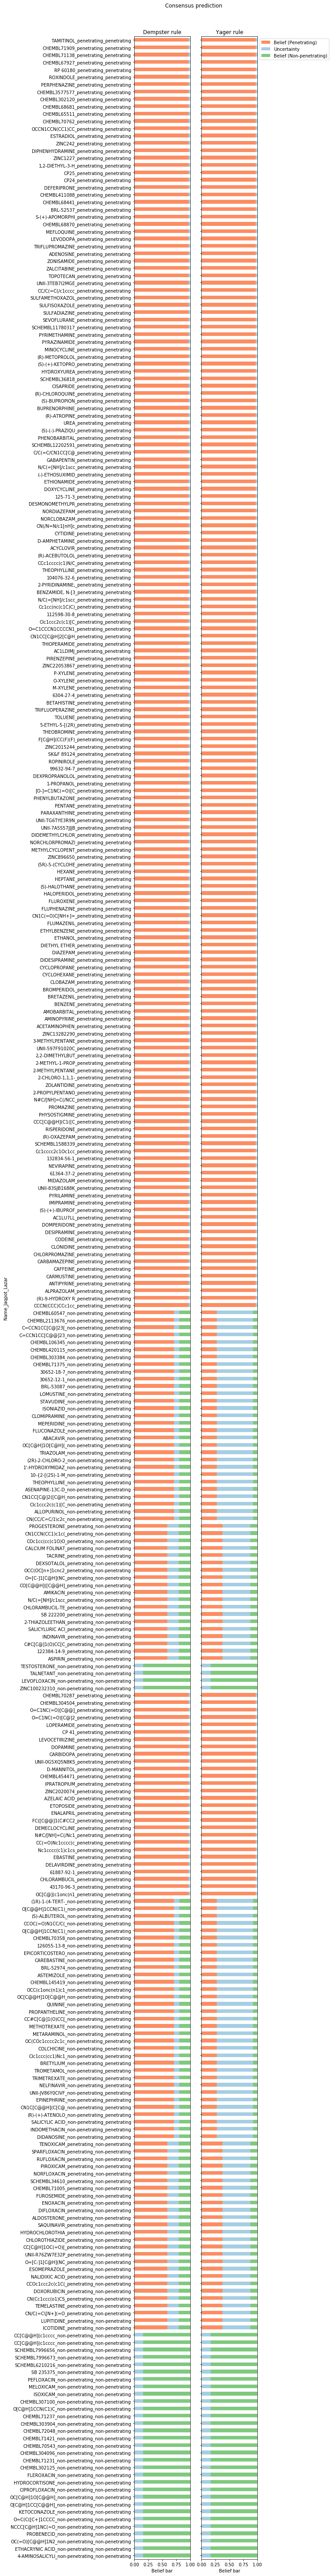

In [271]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(30, 110))


# PLOT 1
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_D'] - consensus_pred['Uncertainty_D']

df_plot = consensus_pred[['Bel_D', 'Uncertainty_D', 'Belief (Non-penetrating)', 'Name_Jaqpot_Lazar']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_D': 'Belief (Penetrating)', 'Uncertainty_D': 'Uncertainty'}).set_index('Name_Jaqpot_Lazar')
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Dempster rule", ax=ax1, legend=False).set_xlabel("Belief bar");


# PLOT 2
# compute belief that compound is non-penetrating
consensus_pred['Belief (Non-penetrating)'] = 1. - consensus_pred['Bel_Y'] - consensus_pred['Uncertainty_Y']

df_plot = consensus_pred[['Bel_Y', 'Uncertainty_Y', 'Belief (Non-penetrating)', 'Name_Jaqpot_Lazar']].copy()

# rename columns (new names will be shown in the plot)
df_plot = df_plot.rename(columns={'Bel_Y': 'Belief (Penetrating)', 'Uncertainty_Y': 'Uncertainty'}).set_index('Name_Jaqpot_Lazar')
df_plot.plot.barh(figsize=(5, 105), stacked=True, color=my_palette, xlim=(0., 1.), title="Yager rule", ax=ax2).set_xlabel("Belief bar");

fig.suptitle("Consensus prediction", y=0.89)

plt.legend(bbox_to_anchor=(1., 1.))
plt.show()

fig.savefig('prediction_vs_true.png', bbox_inches='tight')

**Print out dataframe and color cells depending on the content**

In [270]:
def highlightSensitisers(val):
    if (val == 'penetrating'):
        return 'background-color: #fc8d62;'
    elif (val =='non-penetrating'):
        return 'background-color: #7fc97f;'
    else:
        return 'background-color: #a6cee3;' 
    
df_plot = consensus_pred.copy()
df_plot = df_plot.set_index('SMILES')

df_plot = df_plot[['True', 'Lazar', 'Jaqpot', 'Pred_Y', 'Pred_D', 'Uncertainty_Y', 'Uncertainty_D']].round(2)
df_plot = df_plot.style.applymap(highlightSensitisers, subset=['True', 'Pred_Y', 'Pred_D', 'Lazar', 'Jaqpot'])

maxval = consensus_pred['Uncertainty_D'].max()*100
df_plot = df_plot.bar(subset=['Uncertainty_D'], align='left', color='#ffff99', width=maxval)

maxval = consensus_pred['Uncertainty_Y'].max()*100
df_plot = df_plot.bar(subset=['Uncertainty_Y'], align='left', color='#ffff99', width=maxval)

df_plot